# Interactive Linear Regression Explorer

Use the sliders below to adjust:
- **Learning Rate**: How big of steps we take during gradient descent
- **Iterations**: How many training steps to run
- **Noise Level**: How noisy the training data is

Watch how these parameters affect the model fitting, loss curve, and parameter convergence!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 5)

In [21]:
# Generate base data
np.random.seed(42)
num_samples = 50
X = np.linspace(0, 10, num_samples) # array of 50 points from 0 to 10

true_rel = 0.02*X**4 - 0.8*X**3 + 10*X**2 - 40*X + 100
# true_rel = 0.008 * X**4 + 0.023 * X**3 + 0.07 * X**2 + 0.3*X + 1  # True relationship power 4

def train_and_visualize(degree, learning_rate=0.01, num_iterations=100, noisiness=2.0):
    """
    Generate data for, train, and visualize a multinomial regression model.
    """

    # Generate noisy data
    np.random.seed(42)
    y = true_rel + np.random.randn(50) * noisiness # y-values for training with noise added
    
    # Precalculate the X-values for each feature/input over every sample; to be multiplied with weights.
    # Each row is 1 training sample, each column is a feature (x^degree, x^(degree-1), ..., x^0)
    X_poly = np.array([[x**i for i in range(degree, -1, -1)] for x in X])
#     np.set_printoptions(precision=3, suppress=True)
#     print(X_poly)

    # Initialize parameters/weights
    # m, b = 0.0, 0.0
    weights = np.zeros(degree + 1) # includes feature where X^0
    # weights = np.array([2.0,-40,250])
    history = {'coeffs': [weights.copy()], 'loss': []}
    
    # Training loop - Gradient Descent
    for i in range(num_iterations):
#         print("\n\n — NEW GRADIENT DESCENT RUN —")
        # Forward pass
        y_pred = X_poly @ weights # matrix-mult each sample's features (X-vals) by current weights to get predicted y
        
        # Compute loss/error (Mean Squared Error)
        loss = np.mean((y - y_pred) ** 2)
        history['loss'].append(loss)
        
        # Compute gradients, ending up with an array where each element corresponds to a gradient value for that weight
        gradients = -2 * X_poly.T @ (y - y_pred) / num_samples
        
        # Update parameters
        weights -= learning_rate * gradients
        
        # Store weight values for viz
        history['coeffs'].append(weights.copy())
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Plot 1: Data and fitted line
    axes[0].scatter(X, y, alpha=0.6, s=50, label='Training Data', color='blue')
    axes[0].plot(X, true_rel, 'g--', linewidth=2.5, label='True line (y=8x^4+3x^3+7x^2+1)', alpha=0.7)
    
    # Plot generalized for all degrees
    X_plot = np.linspace(X.min(), X.max(), 100)     # plot 100 points for smooth curve
    X_plot_poly = np.array([[x**i for i in range(degree, -1, -1)] for x in X_plot]) # calculate the polynomial features (X^n) for each plot point
    y_plot = X_plot_poly @ weights # get predicted y-values for plot points using final weights
    
    def format_polynomial_equation(weights, degree):
        """Format polynomial equation as string like 'y=2.5x^3-1.2x^2+3.1x+5.0'"""
        terms = []

        for j, coeff in enumerate(weights):
            power = degree - j

            # Skip very small coefficients
            if abs(coeff) < 0.001:
                continue

            # Format coefficient with sign
            if len(terms) == 0:  # First term
                sign = "" if coeff >= 0 else "-"
                coeff_str = f"{abs(coeff):.2f}"
            else:  # Subsequent terms
                sign = "+" if coeff >= 0 else "-"
                coeff_str = f"{abs(coeff):.2f}"

            # Format the term based on power
            if power == 0:
                term = f"{sign}{coeff_str}"
            elif power == 1:
                term = f"{sign}{coeff_str}x"
            else:
                term = f"{sign}{coeff_str}x^{power}"

            terms.append(term)

        return "y=" + "".join(terms)

    # Use it in your plot:
    equation = format_polynomial_equation(weights, degree)
    axes[0].plot(X_plot, y_plot, 'r-', linewidth=2.5, label=f'Fitted line: {equation}')
    
#     axes[0].plot(X_plot, y_plot, 'r-', linewidth=2.5, 
#                  label=f'Fitted line')
    
    axes[0].set_xlabel('X', fontsize=12)
    axes[0].set_ylabel('y', fontsize=12)
    axes[0].set_title(f'Multinomial Regression Result \n(degree {degree}; noise_mult {noisiness}); learnin {learning_rate})', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Loss over time
    axes[1].plot(np.log(history['loss']), linewidth=2.5, color='purple')
    axes[1].set_xlabel('Iteration', fontsize=12)
    axes[1].set_ylabel('Loss (MSE)', fontsize=12)
    axes[1].set_title(f'Loss During Training (LR {learning_rate})', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Parameter evolution
    coeffs_history = np.array(history['coeffs'])
    labels = [f'x^{degree-j}' if degree-j>1 else
              ('x' if degree-j == 1 else 'the const feature!') 
              for j in range(degree + 1)]

    # Plot all coefficients
    for j, label in enumerate(labels):
        axes[2].plot(coeffs_history[:, j], label=label, linewidth=2.5)
        # Add horizontal line at final value
        axes[2].axhline(y=weights[j], color=f'C{j}', linestyle='--', 
                        alpha=0.5, linewidth=2)
        
    # axes[2].plot(history['m'], label='m (slope)', linewidth=2.5)
    # axes[2].plot(history['b'], label='b (intercept)', linewidth=2.5
    # axes[2].axhline(y=2, color='g', linestyle='--', alpha=0.5, linewidth=2, label='True m=2')
    # axes[2].axhline(y=1, color='b', linestyle='--', alpha=0.5, linewidth=2, label='True b=1')

    axes[2].set_xlabel('Iteration', fontsize=12)
    axes[2].set_ylabel('Parameter Value', fontsize=12)
    axes[2].set_title('Parameter Evolution', fontsize=14, fontweight='bold')
    axes[2].legend(fontsize=10)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    final_loss = history['loss'][-1]
    print(f"\n{'='*60}")
    print(f"Training Results")
    print(f"{'='*60}")
    print(f"Parameters Used:")
    print(f"  Fitted model degree:  {degree:.4f}")
    print(f"  Learning Rate:  {learning_rate:.4f}")
    print(f"  Iterations:     {num_iterations}")
    print(f"  Noise Level:    {noisiness:.2f}")
    print(f"\nFinal Results:")
    for i in range(degree + 1):
        print(f"  w{i} (x^{degree-i} coeff): {weights[i]:.4f}")
    # print(f"  m (slope):      {m:.4f}  (true: 2.0000)  [error: {abs(m-2):.4f}]")
    # print(f"  b (intercept):  {b:.4f}  (true: 1.0000)  [error: {abs(b-1):.4f}]")
    print(f"  Final Loss:     {final_loss:.4f}")
    print(f"{'='*60}")
    
    # Provide interpretation
    if learning_rate < 0.005:
        print("\n💡 Learning rate is quite low - convergence is slow but stable.")
    elif learning_rate > 0.2:
        print("\n⚠️  Learning rate is high - watch for oscillation or divergence!")
    
    if final_loss > 10:
        print("💡 High loss - try more iterations or adjust learning rate.")
    elif final_loss < 5:
        print("✅ Good convergence achieved!")

## Interactive Visualization

Move the sliders to see how different hyperparameters affect training:

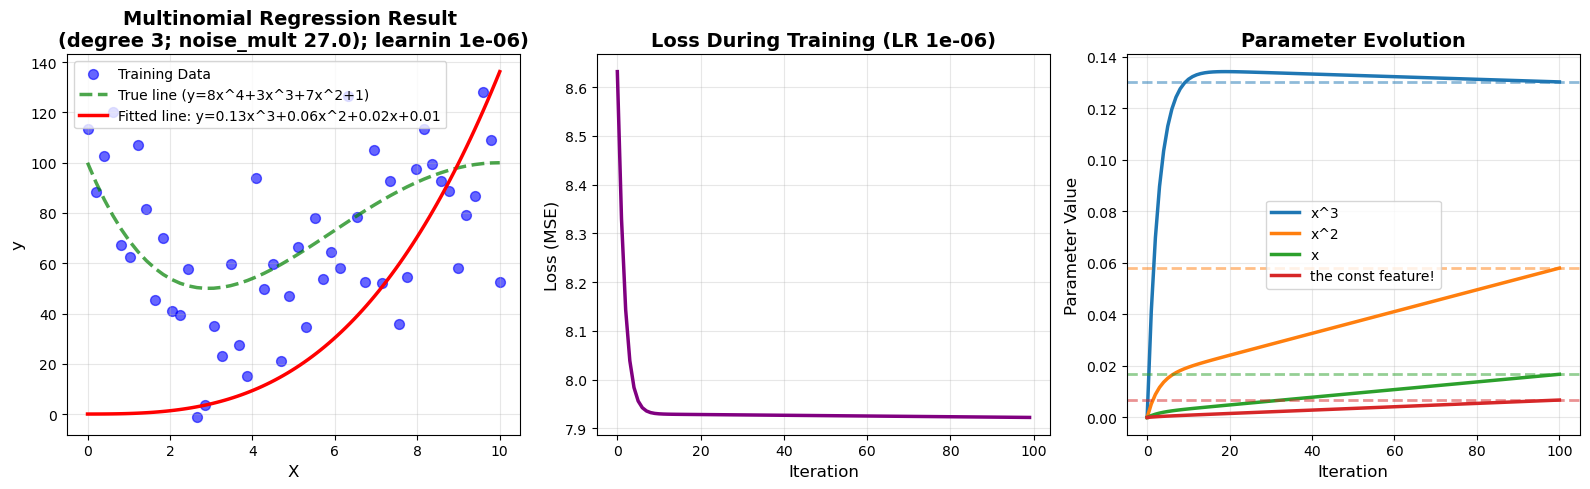


Training Results
Parameters Used:
  Fitted model degree:  3.0000
  Learning Rate:  0.0000
  Iterations:     100
  Noise Level:    27.00

Final Results:
  w0 (x^3 coeff): 0.1303
  w1 (x^2 coeff): 0.0580
  w2 (x^1 coeff): 0.0168
  w3 (x^0 coeff): 0.0068
  Final Loss:     2758.7707

💡 Learning rate is quite low - convergence is slow but stable.
💡 High loss - try more iterations or adjust learning rate.


interactive(children=(IntSlider(value=3, continuous_update=False, description='Degree of multinomial model:', …

In [22]:
interact(
    train_and_visualize,
    degree=IntSlider(
        value=3,
        description='Degree of multinomial model:',
        style={'description_width': 'initial'},
        continuous_update=False
    ),
    learning_rate=FloatSlider(
        value=0.000001,
        description='Learning Rate:',
        style={'description_width': 'initial'},
        continuous_update=False
    ),
    num_iterations=IntSlider(
        value=100,
        step=10,
        description='Iterations:',
        style={'description_width': 'initial'},
        continuous_update=False
    ),
    noisiness=FloatSlider(
        value=27,
        step=0.1,
        description='Noise Level:',
        style={'description_width': 'initial'},
        continuous_update=False
    )
);

## Experiments to Try

1. **Too Small Learning Rate**: Set learning rate to 0.001 - notice how slowly it converges
2. **Too Large Learning Rate**: Set learning rate to 0.3+ - watch for oscillation in the parameter evolution plot
3. **High Noise**: Set noise to 4.0+ - see how it affects the final fit quality
4. **Few Iterations**: Set iterations to 20 - model doesn't have enough time to converge
5. **Sweet Spot**: Learning rate ~0.01-0.05, 100-200 iterations, noise ~2.0

## What to Observe

- **Left plot**: How well does the red line fit the blue data points?
- **Middle plot**: Does the loss decrease smoothly? Does it oscillate?
- **Right plot**: Do the parameters (m and b) converge to the true values (green/blue dashed lines)?